In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from backtest_functions_v2 import *

### aggreation

In [2]:
df = pd.read_parquet('../data/3b.cryptonews_absa.parquet')
df.drop(columns=['title', 'text'] , inplace=True)

df.index = pd.to_datetime(df['date'])
df.drop(columns=['date'], inplace=True)

print(df.shape)
df.head()

(155376, 7)


,source_name,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa
date,,,,,,,
2021-01-02 00:20:00+00:00,Forbes,0.5,0.0,0.0,0.0,0.0,0.0
2021-01-01 20:31:35+00:00,BeInCrypto,0.0,0.5,0.0,0.0,0.7,0.0
2021-01-01 19:15:02+00:00,Coindesk,0.0,0.3,0.0,0.5,0.7,0.0
2021-01-01 18:52:00+00:00,Cointelegraph,1.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 18:00:00+00:00,Bitcoinist,0.3,0.0,0.0,0.0,0.0,0.0


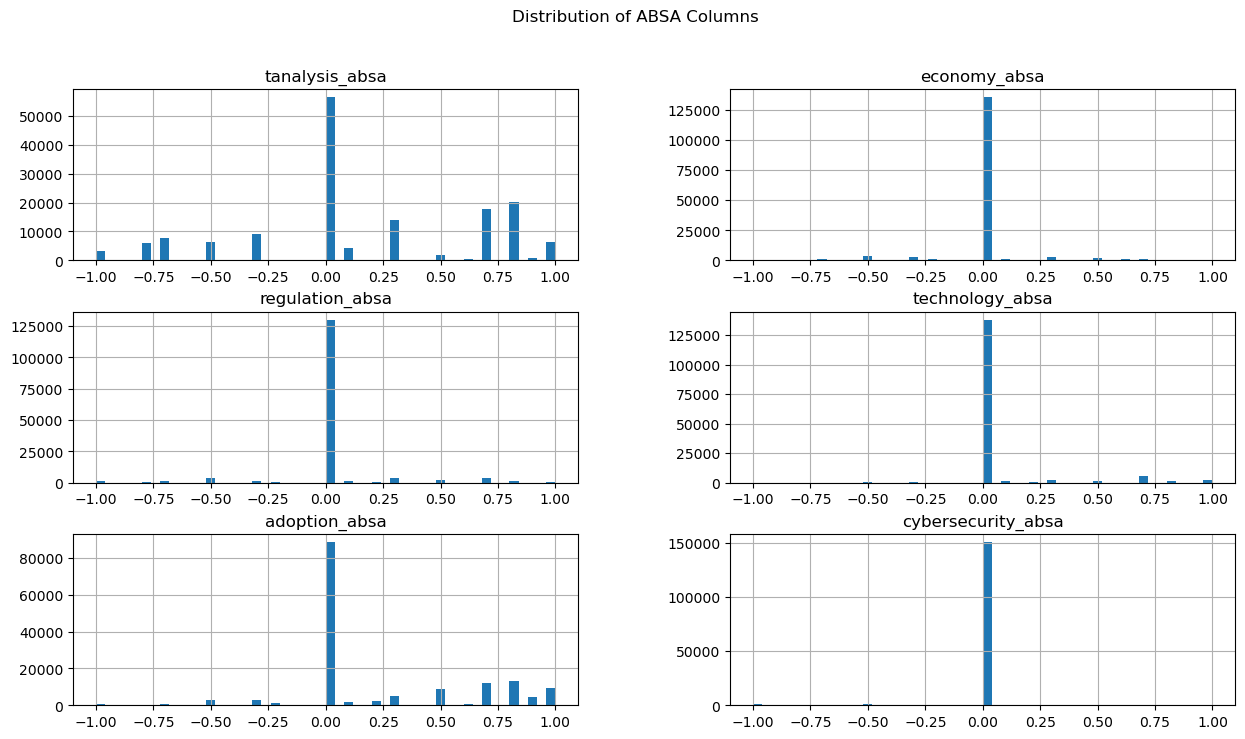

In [3]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df[cols].hist(bins=50, figsize=(15, 8))
plt.suptitle('Distribution of ABSA Columns')
plt.show()

In [4]:
# cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
# df[cols] = df[cols].replace(0, pd.NA)
# df.head()

In [5]:
print("total number of rows in the dataset:", df.shape[0])

df_all_na = df[df[cols].isna().all(axis=1)]
print('number of columns with NA value in all 6 absa columns:', df_all_na.shape[0])

df_non_na = df.dropna(subset=cols, how='all')
print('number of columns with at least one non-NA value in 6 absa columns:', df_non_na.shape[0])

total number of rows in the dataset: 155376
number of columns with NA value in all 6 absa columns: 0
number of columns with at least one non-NA value in 6 absa columns: 155376


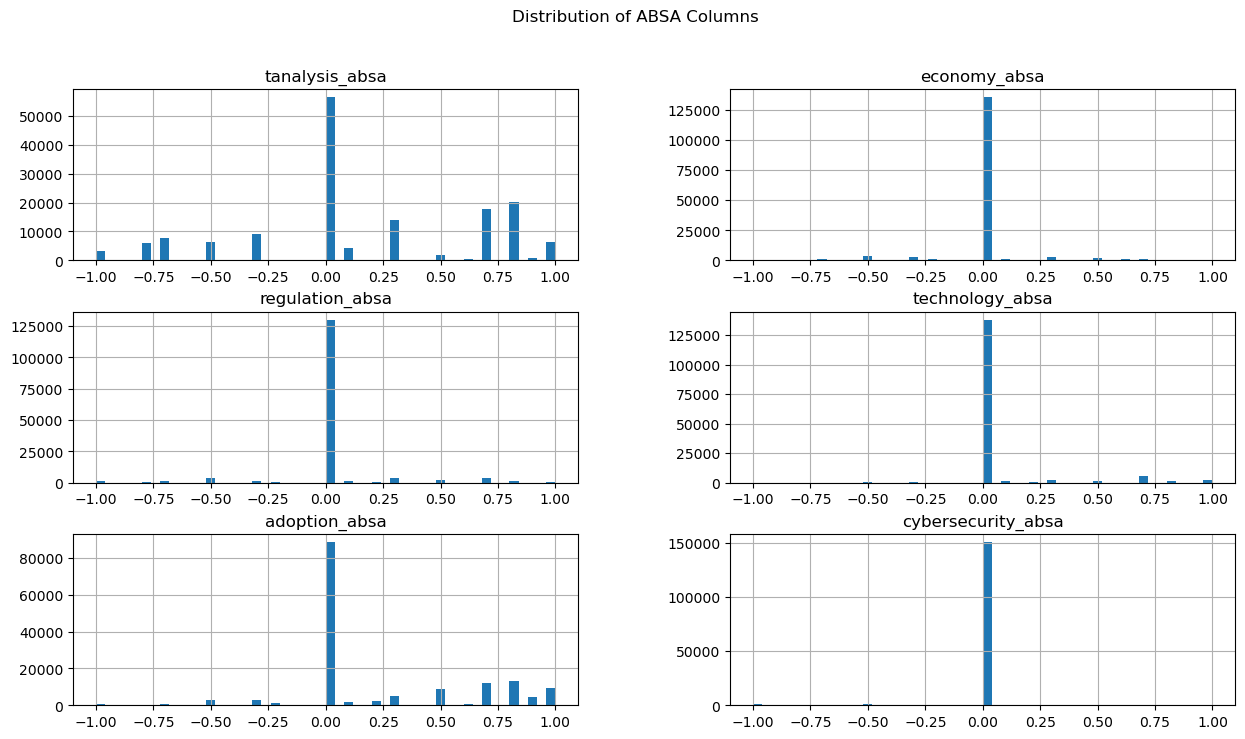

In [6]:
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df[cols].hist(bins=50, figsize=(15, 8))
plt.suptitle('Distribution of ABSA Columns')
plt.show()

In [7]:
df.head()

,source_name,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa
date,,,,,,,
2021-01-02 00:20:00+00:00,Forbes,0.5,0.0,0.0,0.0,0.0,0.0
2021-01-01 20:31:35+00:00,BeInCrypto,0.0,0.5,0.0,0.0,0.7,0.0
2021-01-01 19:15:02+00:00,Coindesk,0.0,0.3,0.0,0.5,0.7,0.0
2021-01-01 18:52:00+00:00,Cointelegraph,1.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 18:00:00+00:00,Bitcoinist,0.3,0.0,0.0,0.0,0.0,0.0


In [8]:
# group by date

aggregation_dict = {
  'tanalysis_absa': 'mean',
  'economy_absa': 'mean',
  'regulation_absa': 'mean',
  'technology_absa': 'mean',
  'adoption_absa': 'mean',
  'cybersecurity_absa': 'mean'
}

df_grouped = df.groupby(pd.Grouper(freq='D')).agg(aggregation_dict)
df_grouped['news_count'] = df.groupby(pd.Grouper(freq='D')).size()
df_grouped

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count
date,,,,,,,
2021-01-01 00:00:00+00:00,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,34
2021-01-02 00:00:00+00:00,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,43
2021-01-03 00:00:00+00:00,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,39
2021-01-04 00:00:00+00:00,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,66
2021-01-05 00:00:00+00:00,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,65
...,...,...,...,...,...,...,...
2024-12-28 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82
2024-12-29 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66
2024-12-30 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206


In [9]:
# last row is 2025-01-01, remove it
df_grouped = df_grouped[df_grouped.index.year < 2025]

# df.index into datetime64[ns]
df_grouped.index = df_grouped.index.values.astype('datetime64[D]')

df_grouped

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count
2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,34
2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,43
2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,39
2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,66
2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,65
...,...,...,...,...,...,...,...
2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,158
2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82
2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66
2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206


In [10]:
df_news = df_grouped.copy()

### strategy baseline: take simple mean of all 6 absa column

In [11]:
df = concat_return(df_news)
df.head()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count,return_forward
2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,34,0.133747
2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,43,-0.008069
2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,39,-0.048455
2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,66,0.073631
2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,65,0.056172


In [12]:
df.describe()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count,return_forward
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,0.129820,-0.013115,0.002911,0.057061,0.226073,-0.014143,106.341547,0.001345
std,0.208611,0.040513,0.063146,0.043041,0.116217,0.020869,56.654991,0.032901
min,-0.616216,-0.284211,-0.486111,-0.084615,-0.111111,-0.202703,18.000000,-0.154932
25%,0.000000,-0.030986,-0.025000,0.028205,0.142609,-0.021622,65.000000,-0.013384
50%,0.134615,-0.006604,0.000000,0.049206,0.222430,-0.008929,98.000000,0.000521
75%,0.268750,0.008403,0.030392,0.078030,0.305000,0.000000,132.000000,0.016509
max,0.769767,0.185638,0.430476,0.446429,0.725000,0.069697,378.000000,0.197580


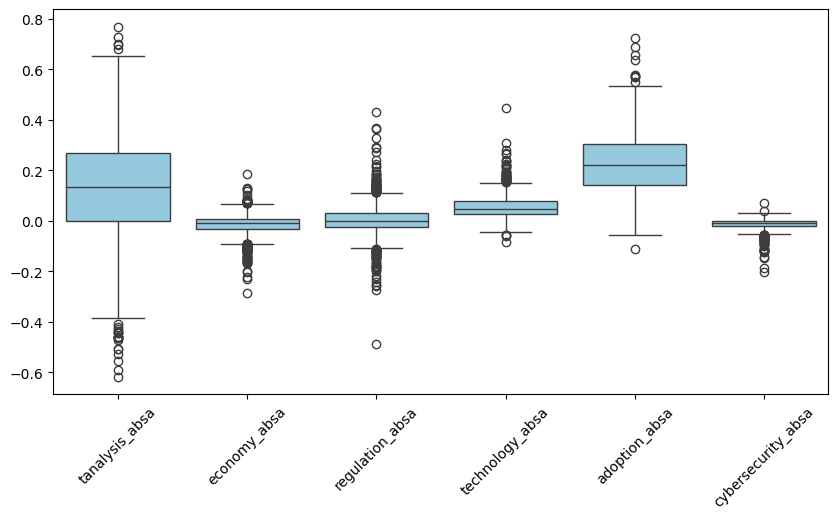

In [13]:
# plot the distribution of the columns
columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[columns], color='skyblue')
plt.xticks(rotation=45)
plt.show()

In [14]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count'], inplace=True)
df.head()

,return_forward,signal
2021-01-01,0.133747,0.147059
2021-01-02,-0.008069,0.141085
2021-01-03,-0.048455,0.151282
2021-01-04,0.073631,0.036111
2021-01-05,0.056172,0.143846


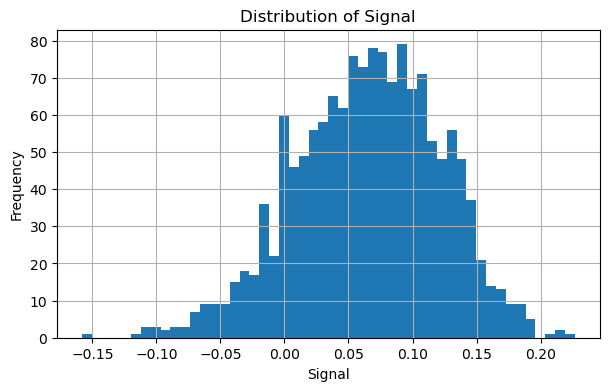

In [15]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Signal smoothing
df['signal'] = df['signal'].ewm(span=3).mean()
# df['signal'] = df['signal'].rolling(window=3).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

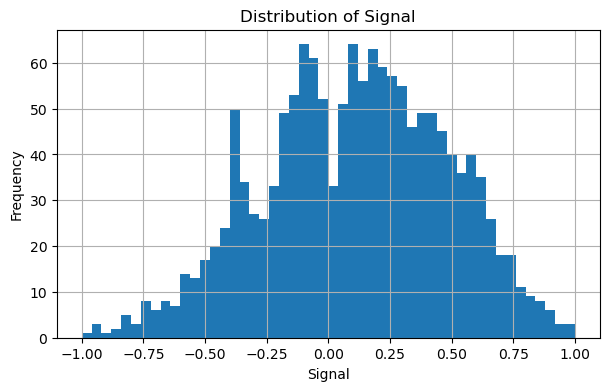

In [17]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

Overall Annual Return: 104.6%
Overall Annual Sharpe Ratio: 3.0366
Maximum Drawdown: -16.2 %
Alpha: 1.039
Beta: 0.0675

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       4.061510    0.320285     0.107261      1.584285       5.229864
1  2022       0.547930    0.230348    -0.227938      0.267372       2.012266
2  2023       0.367185    0.184669     0.189323      0.128433       1.786140
3  2024       0.636855    0.221751     0.279841      0.261804       2.333290


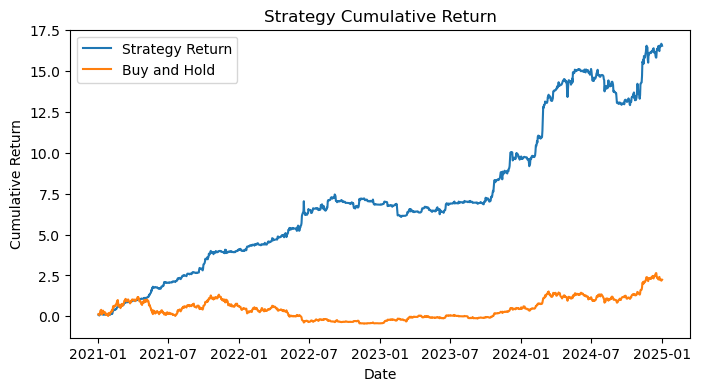

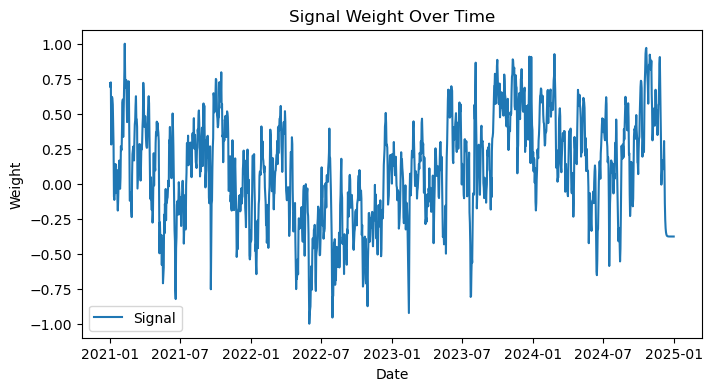

In [18]:
run_backtest(df)

Overall Annual Return: 155.28%
Overall Annual Sharpe Ratio: 2.3333
Maximum Drawdown: -26.23 %
Alpha: 0.6875
Beta: 0.5597

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        1.55277    0.443502     0.559683      0.523607        2.33329


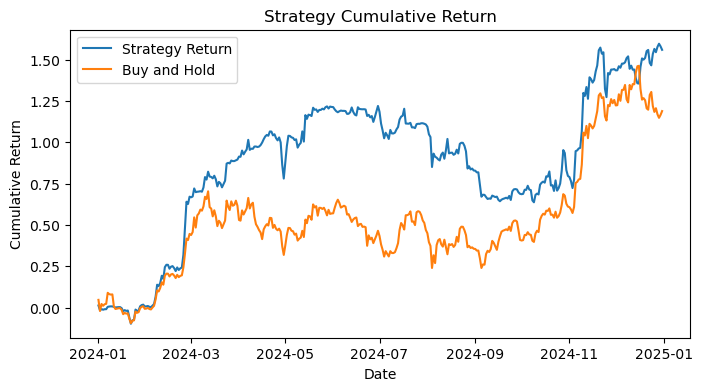

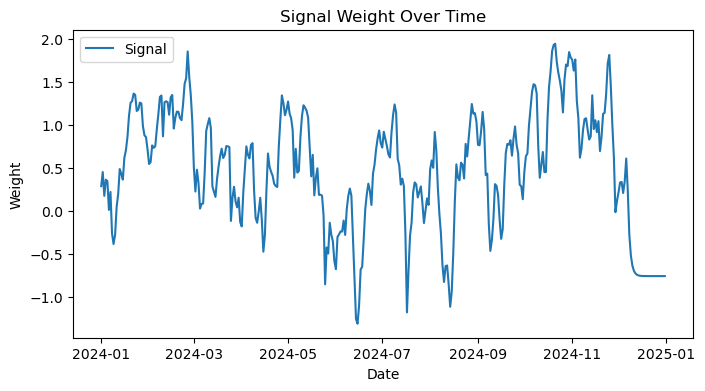

In [19]:
# backtest 2024 only
df = df[df.index.year == 2024]

df['signal'] = df['signal'] * 2

run_backtest(df)

### investigate each feature

In [20]:
df = concat_return(df_news)
df.head()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count,return_forward
2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,34,0.133747
2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,43,-0.008069
2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,39,-0.048455
2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,66,0.073631
2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,65,0.056172


In [21]:
df.columns

Index(['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa',
       'adoption_absa', 'cybersecurity_absa', 'news_count', 'return_forward'],
      dtype='object')

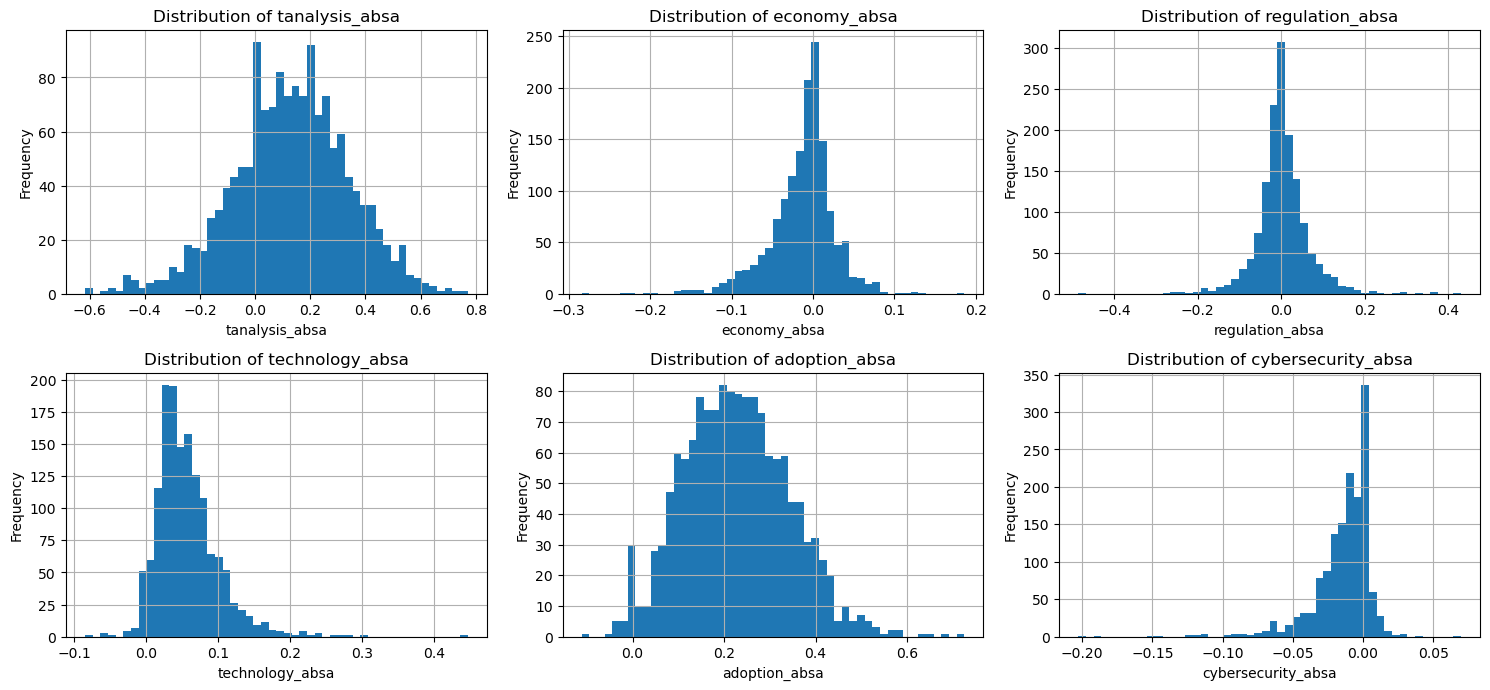

In [22]:
# plot the distribution of the columns
# columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
#        'technology_absa', 'adoption_absa', 'cybersecurity_absa', 'return_forward']

columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
  df[column].hist(ax=axes[i], bins=50)
  axes[i].set_title(f'Distribution of {column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(columns), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

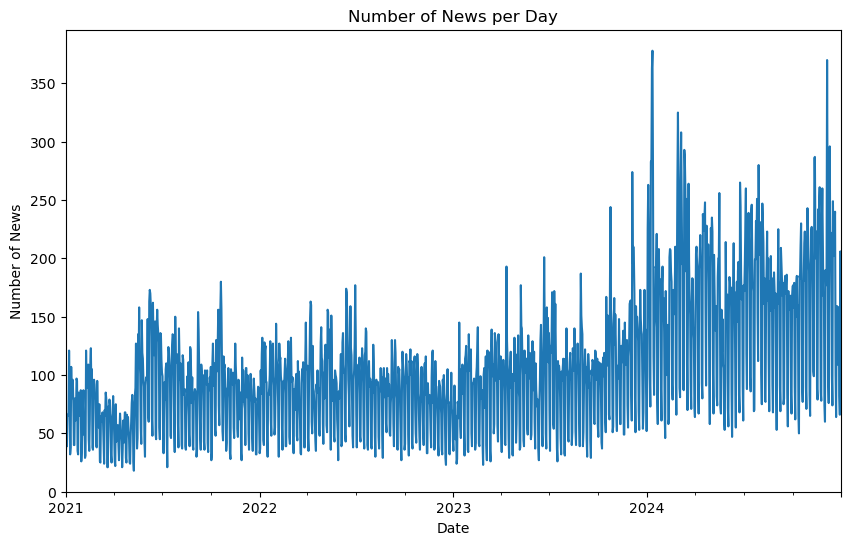

In [23]:
df['news_count'].plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of News')
plt.title('Number of News per Day')
plt.show()

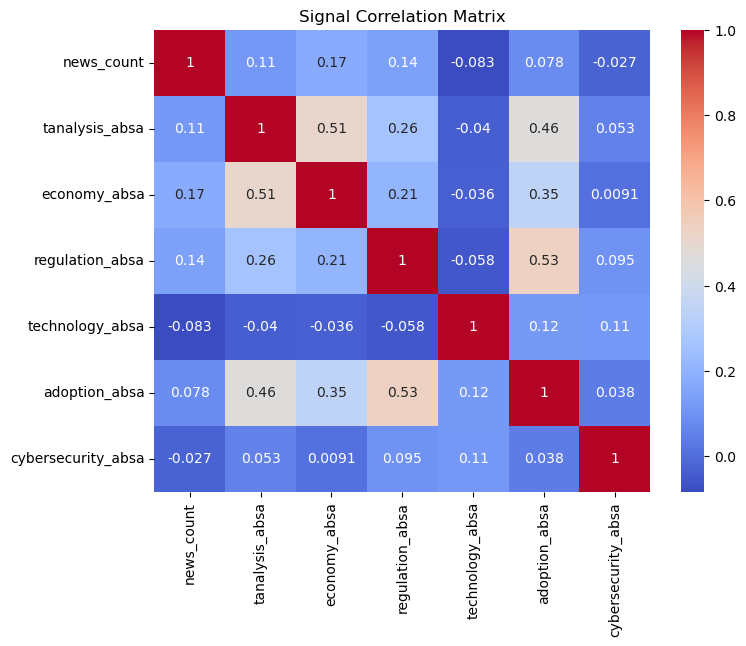

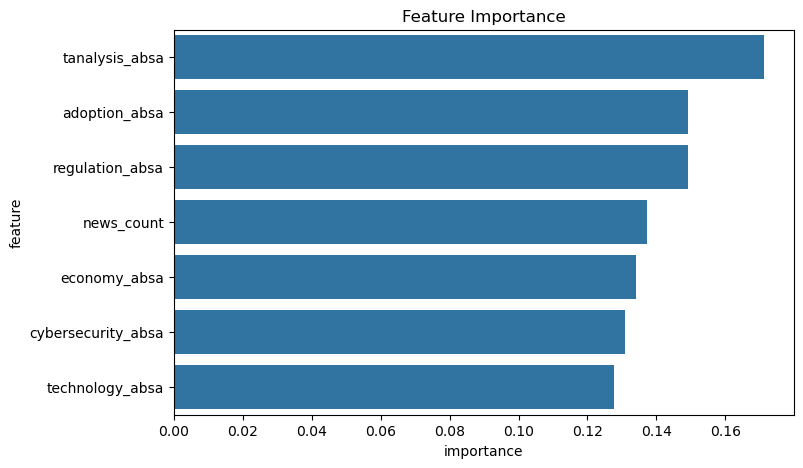


Statistical Analysis:
              feature    f_score       p_value
1      tanalysis_absa  31.536852  2.339474e-08
5       adoption_absa  19.693689  9.773105e-06
3     regulation_absa   4.058625  4.412945e-02
4     technology_absa   2.658332  1.032245e-01
2        economy_absa   2.397331  1.217594e-01
6  cybersecurity_absa   0.341259  5.591935e-01
0          news_count   0.146762  7.017049e-01


In [24]:
def analyze_features(df, signal_columns):
  # 1. Correlation Analysis
  correlation_matrix = df[signal_columns].corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title('Signal Correlation Matrix')
  plt.show()
  
  # 2. Feature Importance using Random Forest
  X = df[signal_columns].fillna(method='ffill').fillna(method='bfill') # Forward fill then backward fill
  y = df['return_forward']
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X, y)
  
  importance_df = pd.DataFrame({
      'feature': signal_columns,
      'importance': rf.feature_importances_
  }).sort_values('importance', ascending=False)
  
  plt.figure(figsize=(8, 5))
  sns.barplot(data=importance_df, x='importance', y='feature')
  plt.title('Feature Importance')
  plt.show()
  
  # 3. Statistical Analysis
  f_scores, p_values = f_regression(X, y)
  stats_df = pd.DataFrame({
    'feature': signal_columns,
    'f_score': f_scores,
    'p_value': p_values
  }).sort_values('f_score', ascending=False)
  
  print("\nStatistical Analysis:")
  print(stats_df)
  
  return correlation_matrix, importance_df, stats_df

signal_columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
corr_matrix, importance, stats = analyze_features(df, signal_columns)

Overall Annual Return: 75.19%
Overall Annual Sharpe Ratio: 2.8268
Maximum Drawdown: -14.13 %
Alpha: 0.8079
Beta: -0.0218

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       2.740495    0.275968     0.010906      1.349391       4.923110
1  2022       0.620708    0.223036    -0.251681      0.291118       2.276308
2  2023       0.174149    0.119801     0.072872      0.090195       1.399997
3  2024       0.324403    0.165217     0.139836      0.166877       1.783123


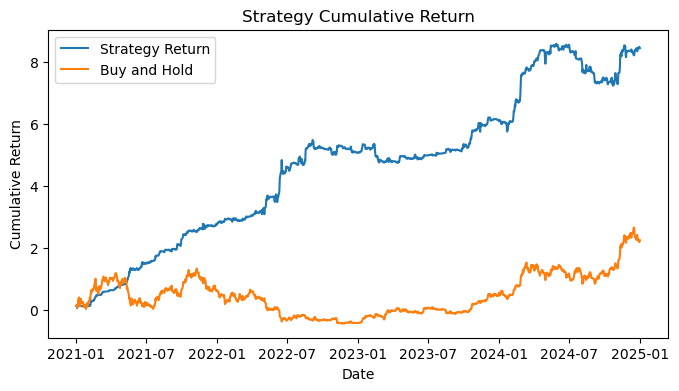

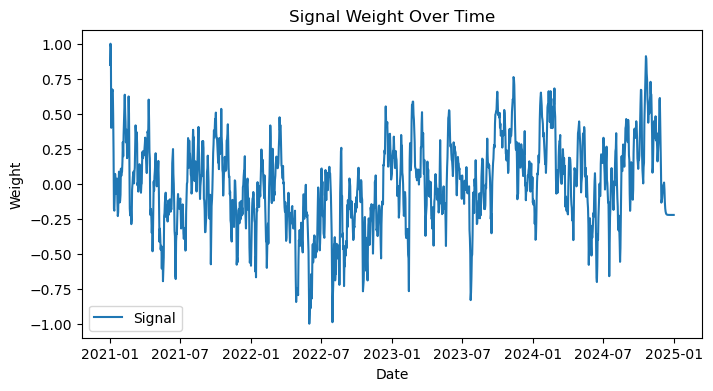

In [25]:
# backtest tanalysis_absa as signal
df['signal'] = df['tanalysis_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=3).mean() # 3 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 44.39%
Overall Annual Sharpe Ratio: 1.694
Maximum Drawdown: -17.65 %
Alpha: 0.3838
Beta: 0.1415

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.677106    0.293496     0.285008      0.318666       1.907474
1  2022       0.446663    0.238717    -0.282432      0.154778       1.666501
2  2023       0.273403    0.138016     0.085053      0.160783       1.820567
3  2024       0.407023    0.234624     0.411063     -0.006446       1.572812


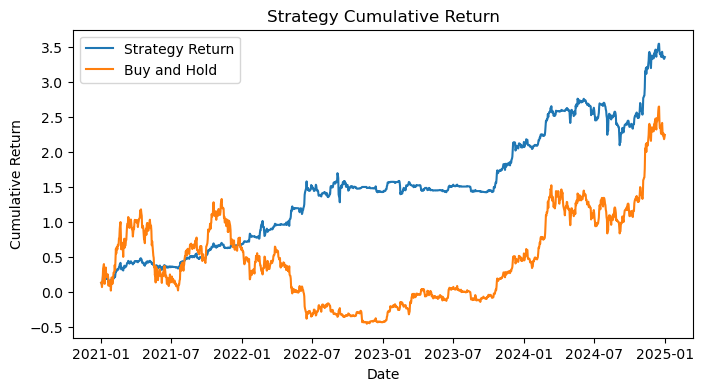

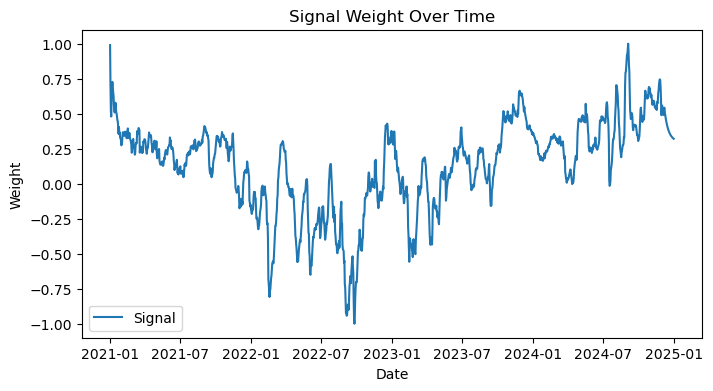

In [26]:
# backtest economy_absa as signal
df['signal'] = df['economy_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=20).mean() # 20 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 12.28%
Overall Annual Sharpe Ratio: 1.3067
Maximum Drawdown: -11.96 %
Alpha: 0.1105
Beta: 0.031

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.278976    0.124674    -0.002240      0.255648       2.035322
1  2022      -0.010191    0.083058     0.024740      0.014459      -0.082245
2  2023       0.079555    0.080193     0.052429      0.023983       0.994602
3  2024       0.162809    0.069610     0.110172      0.052650       2.202004


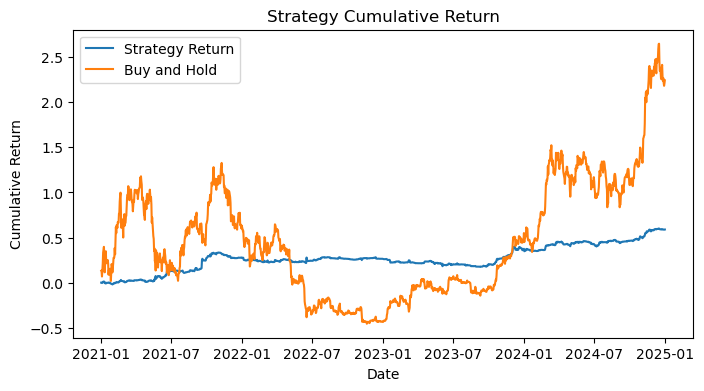

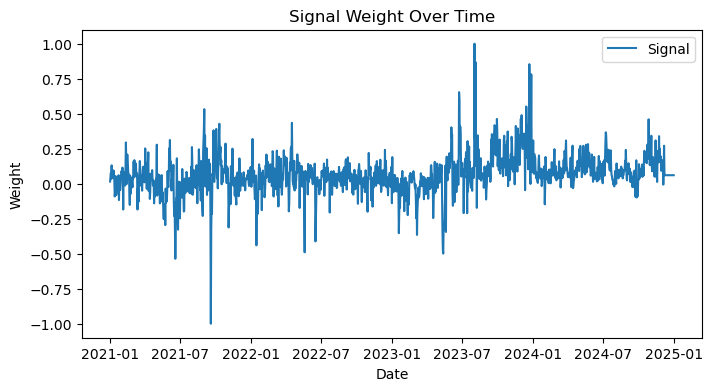

In [27]:
# backtest regulation_absa as signal
df['signal'] = df['regulation_absa']
df['signal'] = df['signal'].fillna(0)
# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: -17.92%
Overall Annual Sharpe Ratio: -0.4558
Maximum Drawdown: -60.57 %
Alpha: 0.0927
Beta: -0.4781

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021      -0.322716    0.447573    -0.504935      0.138027      -0.646245
1  2022       0.411891    0.317318    -0.493534     -0.029791       1.244539
2  2023      -0.282544    0.195738    -0.336435      0.045228      -1.597486
3  2024      -0.338023    0.266985    -0.502558      0.082451      -1.410505


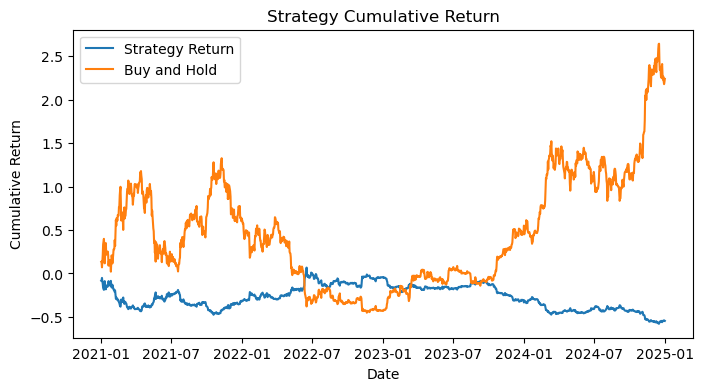

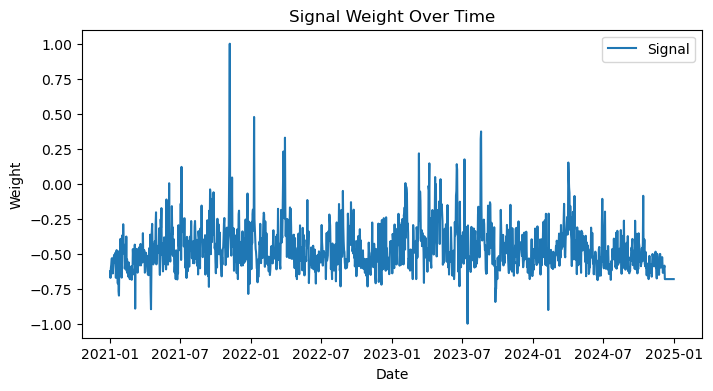

In [28]:
# backtest technology_absa as signal
df['signal'] = df['technology_absa']
df['signal'] = df['signal'].fillna(0)

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 39.73%
Overall Annual Sharpe Ratio: 1.6617
Maximum Drawdown: -26.84 %
Alpha: 0.5164
Beta: -0.1197

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.820489    0.240896    -0.028240      0.652339       2.608769
1  2022       0.554540    0.270025    -0.389109      0.142556       1.767979
2  2023      -0.061263    0.172401    -0.114154      0.073184      -0.279920
3  2024       0.434953    0.156600     0.014416      0.360326       2.385023


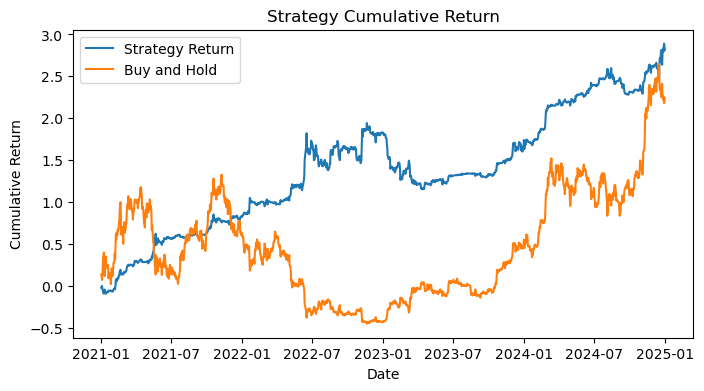

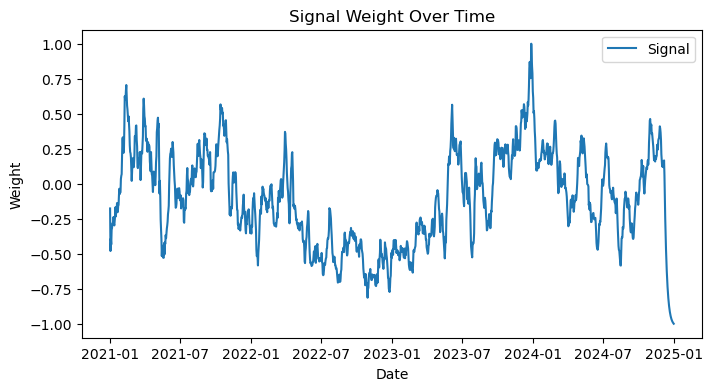

In [29]:
# backtest adoption_absa as signal
df['signal'] = df['adoption_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=12).mean() # 12 days ewm gives the best result

# no smothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 19.84%
Overall Annual Sharpe Ratio: 0.8072
Maximum Drawdown: -45.04 %
Alpha: 0.0206
Beta: 0.4003

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.439278    0.355847     0.397922      0.090241       1.199834
1  2022      -0.412312    0.260278     0.395146     -0.157035      -1.909776
2  2023       0.608712    0.216368     0.410721      0.061572       2.304030
3  2024       0.514792    0.215303     0.402087      0.071252       2.036744


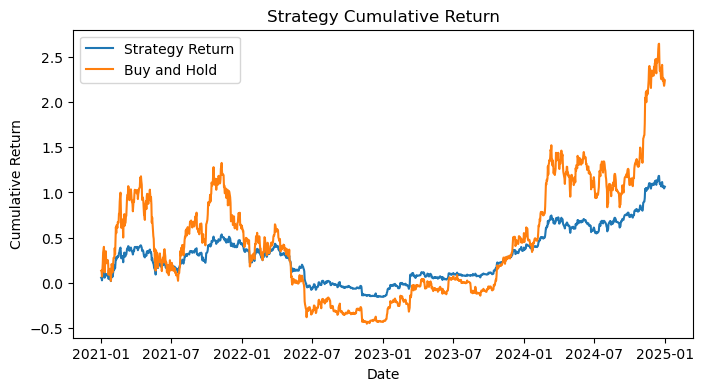

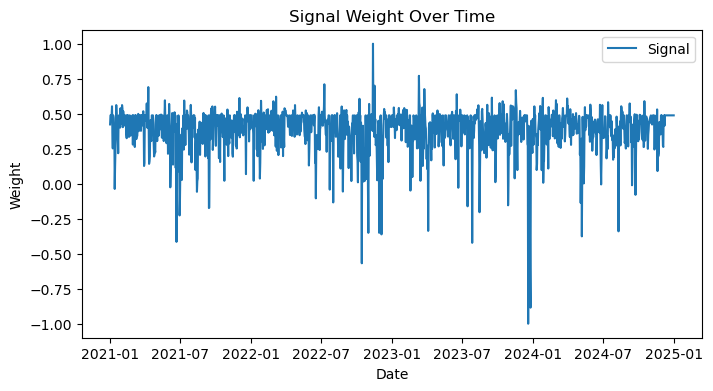

In [30]:
# backtest cybersecurity_absa as signal
df['signal'] = df['cybersecurity_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

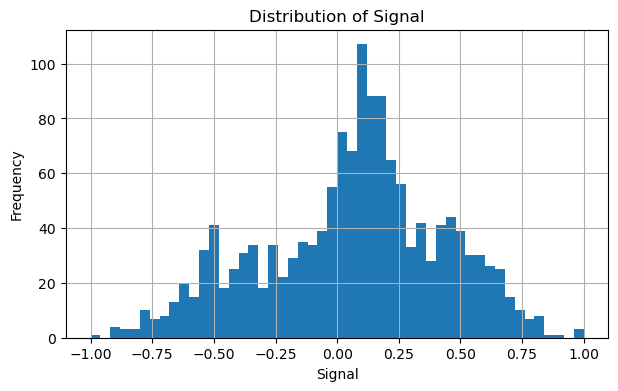

Overall Annual Return: 3.53%
Overall Annual Sharpe Ratio: 0.2655
Maximum Drawdown: -39.42 %
Alpha: 0.0728
Beta: -0.012

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021      -0.107599    0.323044    -0.169381      0.082215      -0.189179
1  2022      -0.084926    0.169787     0.001494     -0.073118      -0.438218
2  2023       0.110327    0.183912    -0.009146      0.131828       0.663893
3  2024       0.266595    0.262426     0.386405     -0.082326       1.031204


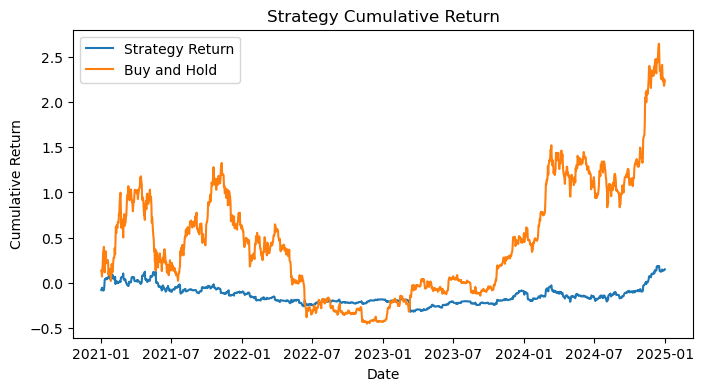

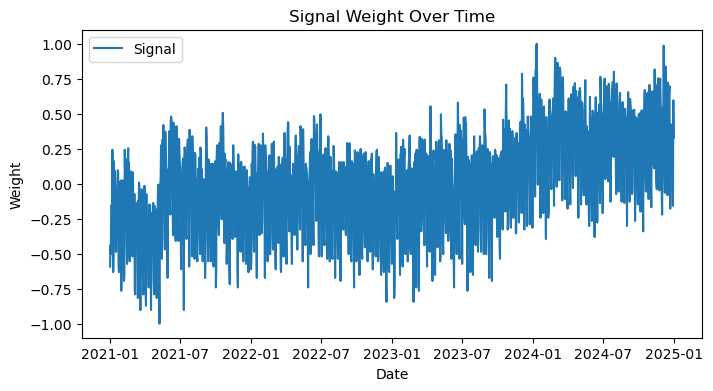

In [31]:
# backtest news_count as signal
df['signal'] = df['news_count']
df['signal'] = df['signal'].fillna(0)

# feature scaling, right skewed, log transformation
df['signal'] = np.log1p(df['signal'])

# scale the signal to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

# plot the distribution of the signal
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

run_backtest(df)


### strategy adjusted based on previous investigatio on each feature
(does not work)

In [32]:
df = concat_return(df_news)
df.head()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count,return_forward
2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,34,0.133747
2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,43,-0.008069
2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,39,-0.048455
2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,66,0.073631
2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,65,0.056172


In [33]:
df.fillna(0, inplace=True)

# apply smoothing based on previous analysis
df['tanalysis_absa'] = df['tanalysis_absa'].ewm(span=3).mean()
df['economy_absa'] = df['economy_absa'].ewm(span=20).mean()

# take mean of all columns
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

df

,news_count,return_forward,signal
2021-01-01,34,0.133747,0.565624
2021-01-02,43,-0.008069,0.504100
2021-01-03,39,-0.048455,0.627884
2021-01-04,66,0.073631,0.202577
2021-01-05,65,0.056172,0.450314
...,...,...,...
2024-12-27,158,0.010311,-0.321297
2024-12-28,82,-0.016628,-0.321526
2024-12-29,66,-0.009930,-0.321733
2024-12-30,206,0.008129,-0.321921


Overall Annual Return: 84.75%
Overall Annual Sharpe Ratio: 3.0066
Maximum Drawdown: -12.07 %
Alpha: 0.8517
Beta: 0.0402

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       3.242970    0.282241     0.075598      1.422894       5.268068
1  2022       0.389226    0.208928    -0.206566      0.172699       1.677402
2  2023       0.294609    0.150737     0.143713      0.116700       1.788481
3  2024       0.527341    0.175698     0.208792      0.248335       2.498858


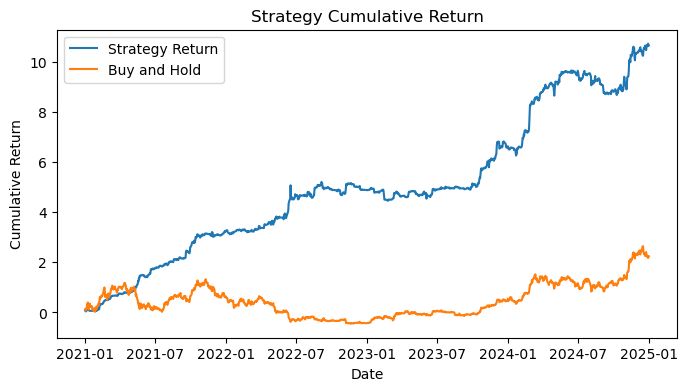

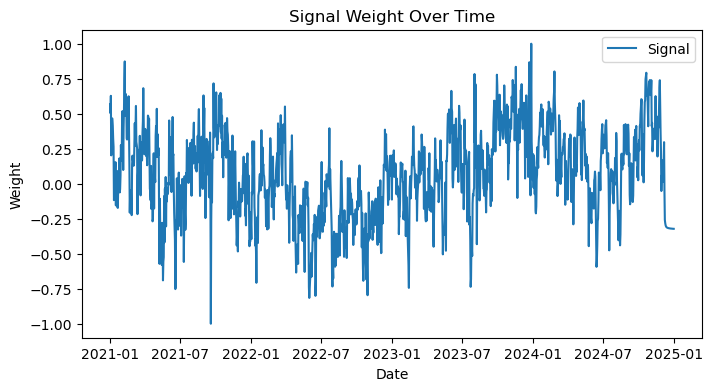

In [34]:
# df = df[df.index.year == 2024]

run_backtest(df)

Overall Annual Return: 226.7%
Overall Annual Sharpe Ratio: 3.0066
Maximum Drawdown: -23.31 %
Alpha: 2.4253
Beta: 0.0804

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021      15.634309    0.564482     0.151196      2.845788       5.268068
1  2022       0.849094    0.417857    -0.413132      0.345397       1.677402
2  2023       0.638554    0.301473     0.287426      0.233400       1.788481
3  2024       1.262649    0.351396     0.417583      0.496669       2.498858


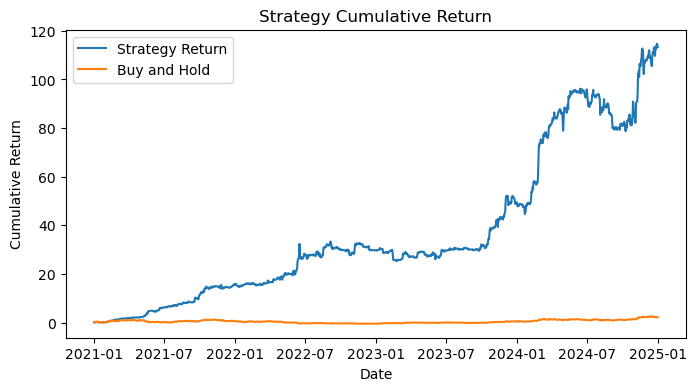

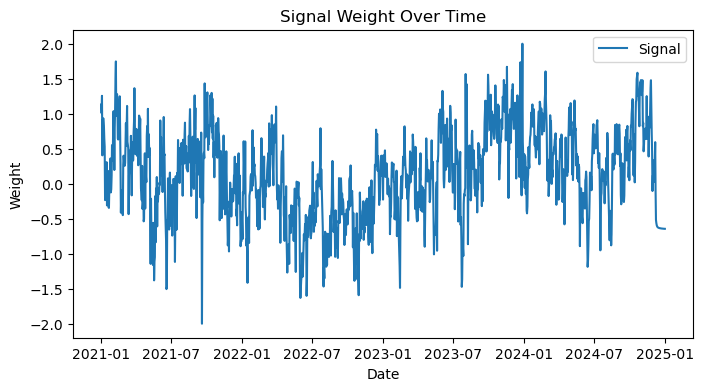

In [35]:
df['signal'] = df['signal'] * 2
run_backtest(df)

Overall Annual Return: 34.14%
Overall Annual Sharpe Ratio: 0.7811
Maximum Drawdown: -76.46 %
Alpha: 0.0
Beta: 1.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.633621    0.845068          1.0           0.0       1.001325
1  2022      -0.651507    0.615854          1.0           0.0      -1.397309
2  2023       1.600096    0.467779          1.0           0.0       2.274261
3  2024       1.184281    0.514850          1.0           0.0       1.774104


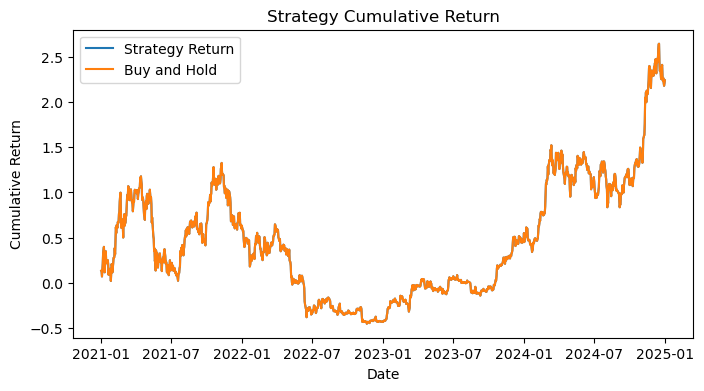

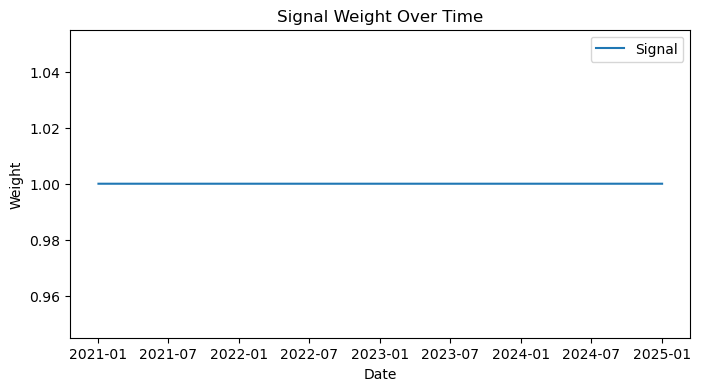

In [36]:
df['signal'] = 1

run_backtest(df)

### reduce trading fee: less frequent trades

In [37]:
df = concat_return(df_news)
df.head()

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,news_count,return_forward
2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,34,0.133747
2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,43,-0.008069
2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,39,-0.048455
2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,66,0.073631
2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,65,0.056172


In [38]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']
df['mean_sentiment'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count', 'cybersecurity_absa'], inplace=True)
df.head()

,return_forward,mean_sentiment
2021-01-01,0.133747,0.178235
2021-01-02,-0.008069,0.169302
2021-01-03,-0.048455,0.181538
2021-01-04,0.073631,0.043333
2021-01-05,0.056172,0.172615


In [39]:
# Signal smoothing
df['mean_sentiment'] = df['mean_sentiment'].ewm(span=3).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['mean_sentiment'] = scaler.fit_transform(df['mean_sentiment'].values.reshape(-1, 1))

In [40]:
df['signal'] = 0
# df['signal'] = np.where(df['mean_sentiment'] > 0.1, 0.5, df['signal'])
# df['signal'] = np.where(df['mean_sentiment'] > 0.2, 1, df['signal'])

df['signal'] = np.where(df['mean_sentiment'] > 0.1, 1, df['signal'])

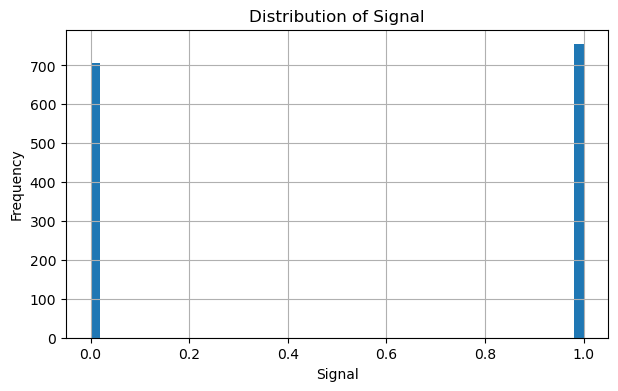

In [41]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

Overall Annual Return: 149.72%
Overall Annual Sharpe Ratio: 2.3435
Maximum Drawdown: -30.57 %
Alpha: 1.1707
Beta: 0.4711

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       5.905696    0.594811     0.505697      1.683390       3.549538
1  2022      -0.002726    0.224097     0.132551      0.136256       0.099024
2  2023       1.062509    0.379948     0.657047      0.095919       2.092178
3  2024       1.736973    0.430995     0.702910      0.457925       2.552141


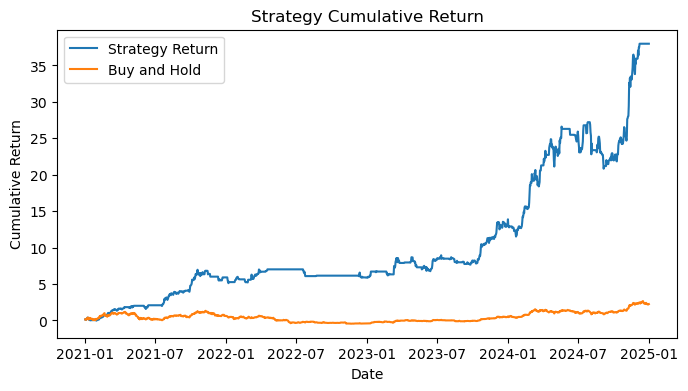

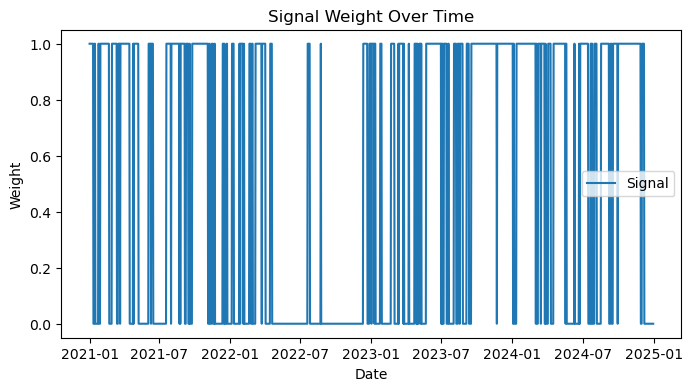

In [42]:
run_backtest(df)

Overall Annual Return: 173.7%
Overall Annual Sharpe Ratio: 2.5521
Maximum Drawdown: -22.63 %
Alpha: 0.5803
Beta: 0.7029

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.736973    0.430995      0.70291      0.457925       2.552141


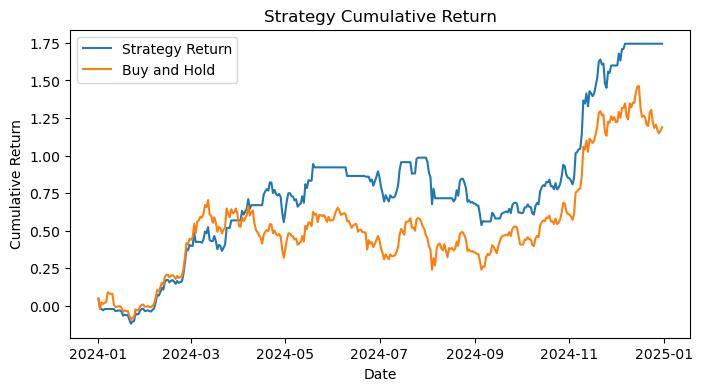

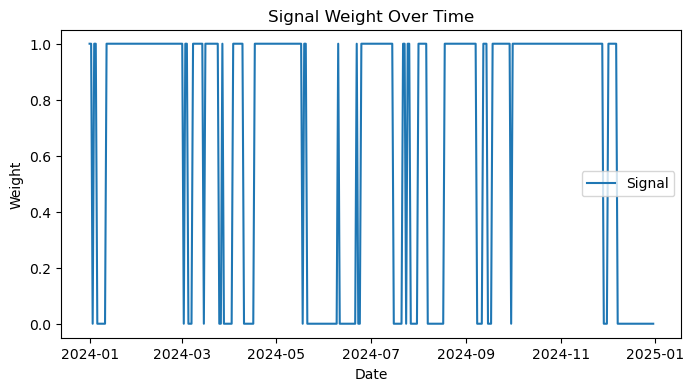

In [43]:
# backtest 2024 only
df = df[df.index.year == 2024]

# df['signal'] = df['signal']

run_backtest(df)